In [1]:
from diffusers import AutoencoderKL

url = "https://huggingface.co/stabilityai/sd-vae-ft-mse-original/blob/main/vae-ft-mse-840000-ema-pruned.safetensors"  # can also be a local file
model = AutoencoderKL.from_single_file(url)

A matching Triton is not available, some optimizations will not be enabled
Traceback (most recent call last):
  File "/home2/ansh.shah/miniconda3/envs/torch/lib/python3.11/site-packages/xformers/__init__.py", line 55, in _is_triton_available
    from xformers.triton.softmax import softmax as triton_softmax  # noqa
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home2/ansh.shah/miniconda3/envs/torch/lib/python3.11/site-packages/xformers/triton/softmax.py", line 14, in <module>
    from xformers.triton.k_softmax import _softmax, _softmax_backward
  File "/home2/ansh.shah/miniconda3/envs/torch/lib/python3.11/site-packages/xformers/triton/k_softmax.py", line 8, in <module>
    import triton.language as tl
ModuleNotFoundError: No module named 'triton.language'
/home2/ansh.shah/miniconda3/envs/torch/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home2/ansh.shah/miniconda3/envs/torch/lib/python3.11/site

In [2]:
model = model.cuda()
model = model.eval()

In [3]:
def normalize(x):
    return (x - x.min()) / (x.max() - x.min())

0.0065231323 1.0
(768, 1024, 3)


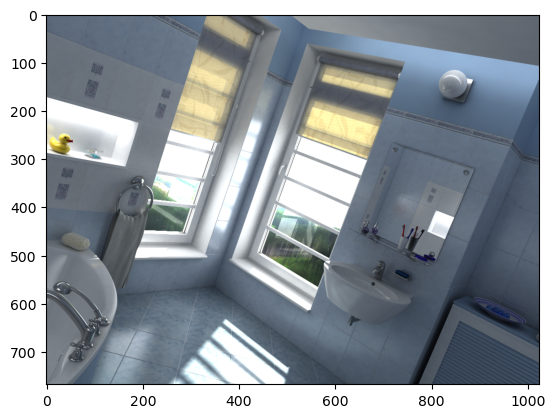

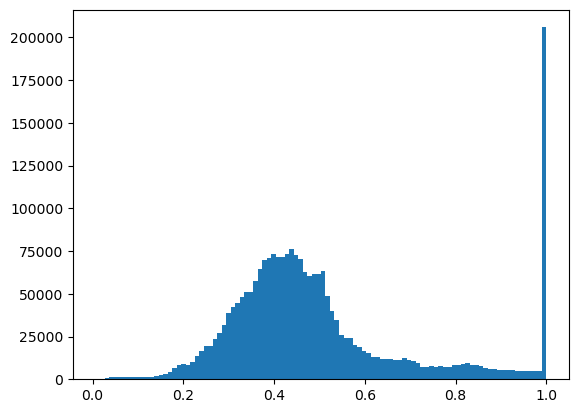

In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
import h5py
import numpy as np

file_path = "/scratch/ansh.shah/ml-hypersim/evermotion_dataset/scenes/ai_001_001/images/scene_cam_00_final_hdf5/frame.0000.color.hdf5"
input = np.array(h5py.File(file_path, 'r')['dataset'], dtype=np.float32).clip(0, 1)

print(input.min(), input.max())

print(input.shape)
plt.imshow(input)
plt.show()

plt.hist(input.flatten(), bins=100)
plt.show()

# input = Image.fromarray(i=)

transform = transforms.Compose([
    # transforms.CenterCrop((256, 256)),
    transforms.ToTensor()
])

in_ = transform(input)
with torch.no_grad():
    output = model(transform(input).unsqueeze(0).cuda())

torch.Size([1, 3, 768, 1024]) 

tensor(-0.1647, device='cuda:0') tensor(1.2386, device='cuda:0')


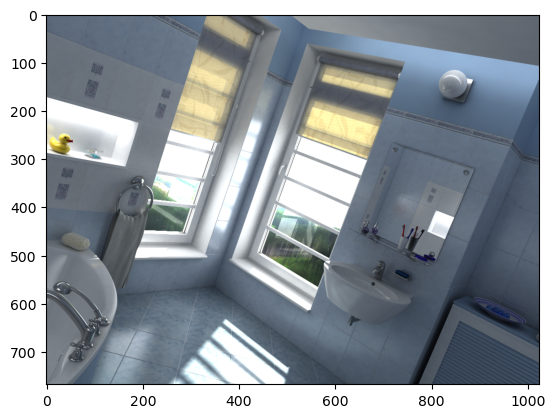

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


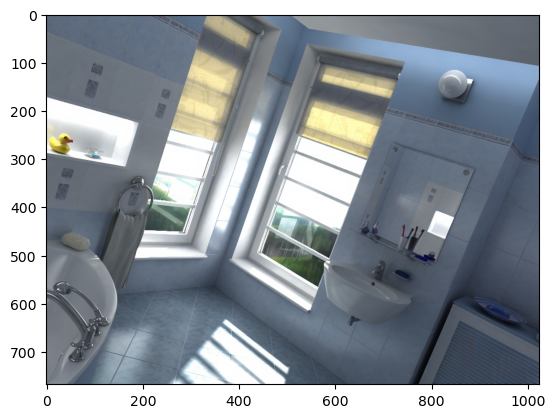

In [5]:
out = output['sample']
print(out.shape, out.min(), out.max())
plt.imshow(in_.permute(1, 2, 0))
plt.show()
plt.imshow(out[0].detach().cpu().permute(1, 2, 0))
plt.show()

tensor(0., device='cuda:0') tensor(0.8034, device='cuda:0')


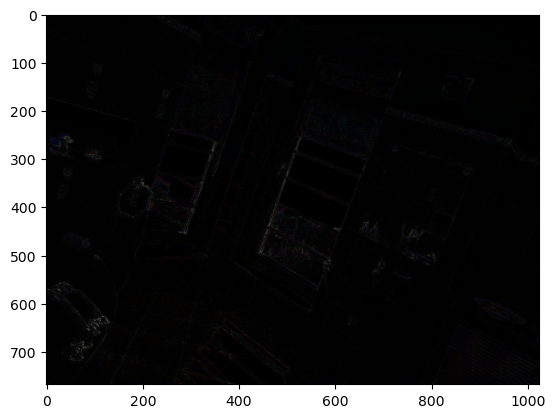

In [6]:
diff = (out - in_.unsqueeze(0).cuda()).abs()
print(diff.min(), diff.max())
plt.imshow(diff[0].detach().cpu().permute(1, 2, 0))
plt.show()

1.9150391 4.2617188


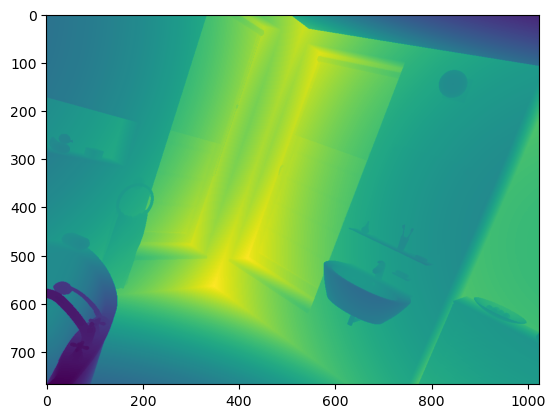

torch.Size([1, 1, 768, 1024])
tensor(1.9150, device='cuda:0') tensor(4.2617, device='cuda:0') tensor(3.3664, device='cuda:0')


In [7]:
#LOAD DEPTHframe.0035.depth_meters.hdf5 


depth_path = "/scratch/ansh.shah/ml-hypersim/evermotion_dataset/scenes/ai_001_001/images/scene_cam_00_geometry_hdf5/frame.0000.depth_meters.hdf5"
depth = np.array(h5py.File(depth_path, 'r')['dataset'], dtype=np.float32)

print(depth.min(), depth.max())

plt.imshow(normalize(depth))
plt.show()

depth = torch.tensor(depth).unsqueeze(0).unsqueeze(0).cuda()
print(depth.shape)
print(depth.min(), depth.max(), depth.mean())

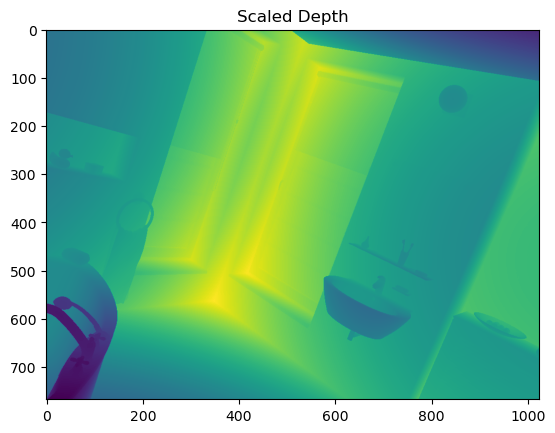

tensor(0., device='cuda:0') tensor(1., device='cuda:0')


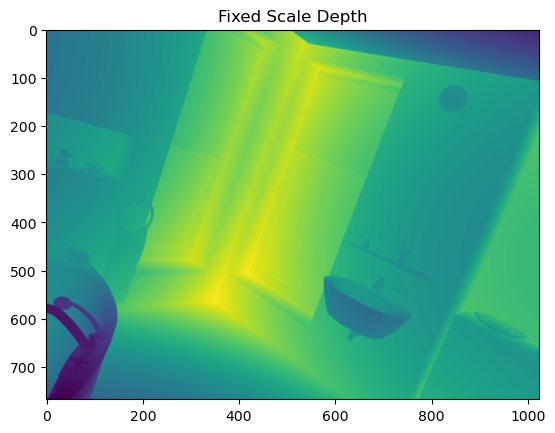

tensor(0.0227, device='cuda:0') tensor(0.0521, device='cuda:0')


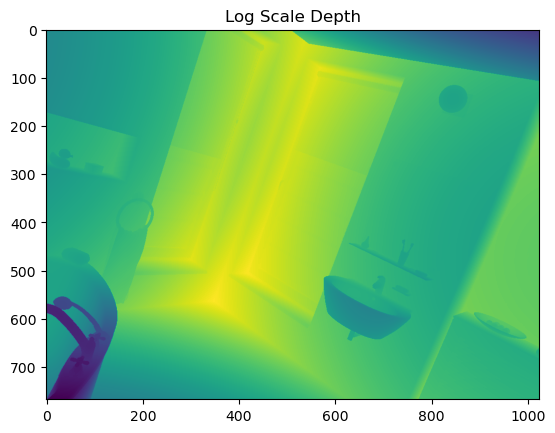

tensor(0.4417, device='cuda:0') tensor(0.5613, device='cuda:0')


In [8]:
scaled_depth = (depth - depth.min()) / (depth.max() - depth.min())
plt.imshow(scaled_depth[0].detach().cpu().squeeze(0))
plt.title("Scaled Depth")
plt.show()
print(scaled_depth.min(), scaled_depth.max())

fixed_scale = (depth - 0.10)/(80 - 0.10)
plt.imshow(fixed_scale[0].detach().cpu().squeeze(0))
plt.title("Fixed Scale Depth")
plt.show()
print(fixed_scale.min(), fixed_scale.max())

log_scale = torch.log(depth/0.10)/np.log(80/0.10)

plt.imshow(log_scale[0].detach().cpu().squeeze(0))
plt.title("Log Scale Depth")
plt.show()
print(log_scale.min(), log_scale.max())

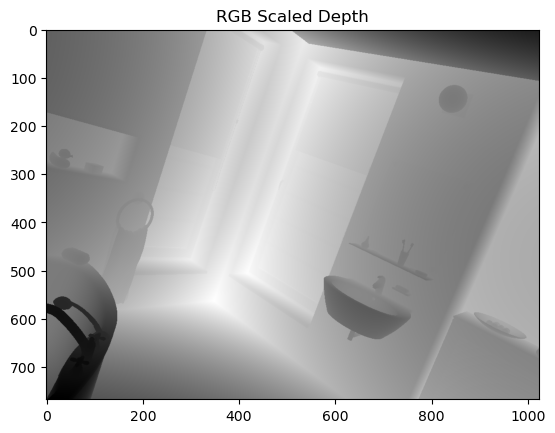

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


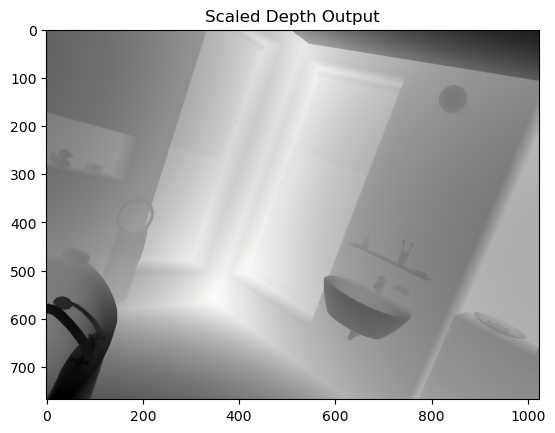

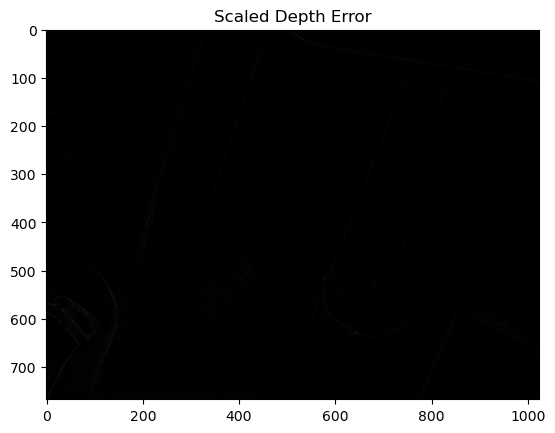

tensor(0.) tensor(0.3558) tensor(0.0030) tensor(0.0050)


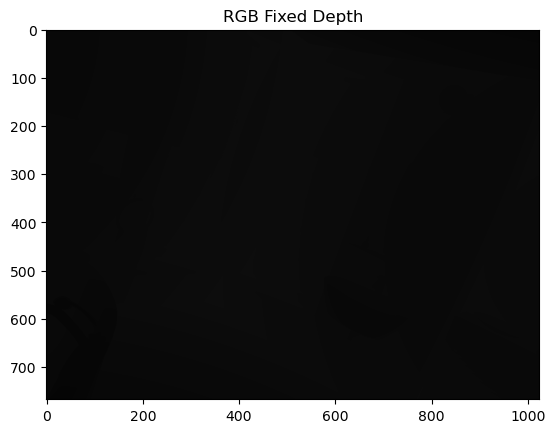

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


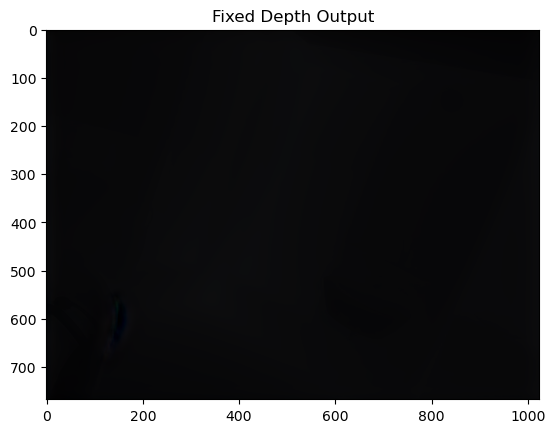

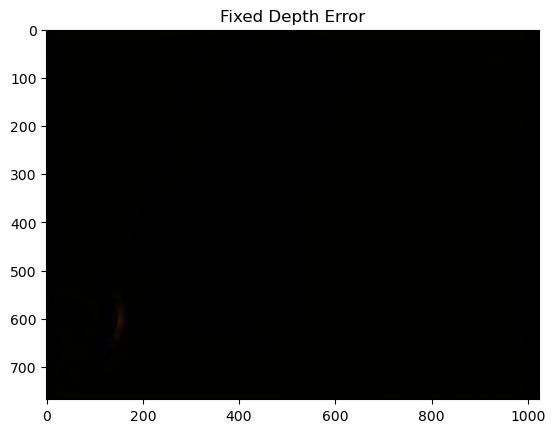

tensor(3.7253e-09) tensor(0.1585) tensor(0.0043) tensor(0.0034)


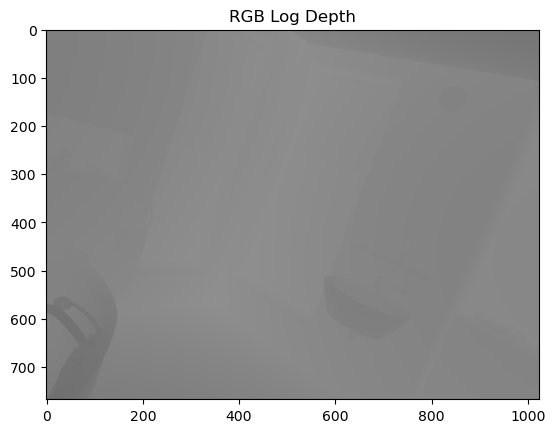

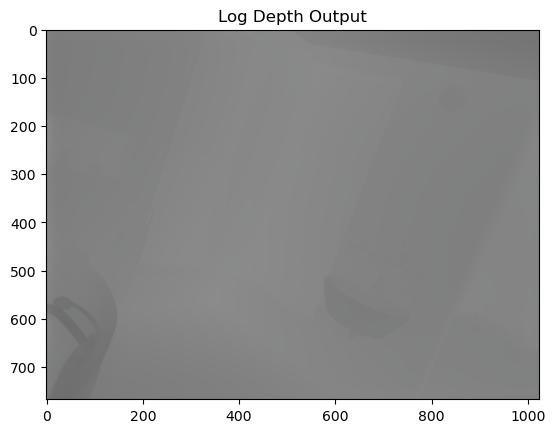

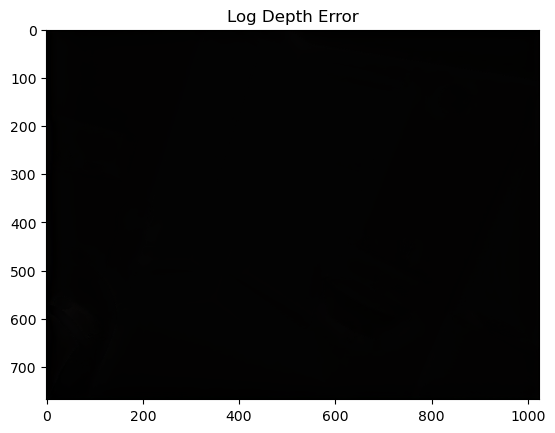

tensor(0.) tensor(0.0675) tensor(0.0119) tensor(0.0024)


In [9]:
rgb_scaled = torch.stack([scaled_depth, scaled_depth, scaled_depth], dim=1).squeeze().float()


rgb_fixed = torch.stack([fixed_scale, fixed_scale, fixed_scale], dim=1).squeeze().float()


rgb_log = torch.stack([log_scale, log_scale, log_scale], dim=1).squeeze().float()


assert rgb_scaled.shape == rgb_fixed.shape == rgb_log.shape and rgb_scaled.min() >= 0 and rgb_scaled.max() <= 1 and rgb_fixed.min() >= 0 and rgb_fixed.max() <= 1 and rgb_log.min() >= 0 and rgb_log.max() <= 1
with torch.no_grad():
    scaled_out = model(rgb_scaled.unsqueeze(0).cuda())['sample']
    fixed_out = model(rgb_fixed.unsqueeze(0).cuda())['sample']
    log_out = model(rgb_log.unsqueeze(0).cuda())['sample']

plt.imshow(rgb_scaled.detach().cpu().permute(1, 2, 0))
plt.title("RGB Scaled Depth")
plt.show()
plt.imshow(scaled_out.detach().cpu().squeeze(0).permute(1, 2, 0))
plt.title("Scaled Depth Output")
plt.show()

error_scaled = abs(scaled_out.detach().cpu().squeeze(0) - rgb_scaled.cpu())
plt.imshow(error_scaled.permute(1, 2, 0))
plt.title("Scaled Depth Error")
plt.show()
print(error_scaled.min(), error_scaled.max(), error_scaled.mean(), error_scaled.std())


plt.imshow(rgb_fixed.detach().cpu().permute(1, 2, 0))
plt.title("RGB Fixed Depth")
plt.show()
plt.imshow(fixed_out.detach().cpu().squeeze(0).permute(1, 2, 0))
plt.title("Fixed Depth Output")
plt.show()
error_fixed = abs(fixed_out.detach().cpu().squeeze(0) - rgb_fixed.cpu())
plt.imshow(error_fixed.permute(1, 2, 0))
plt.title("Fixed Depth Error")
plt.show()
print(error_fixed.min(), error_fixed.max(), error_fixed.mean(), error_fixed.std())

plt.imshow(rgb_log.detach().cpu().permute(1, 2, 0))
plt.title("RGB Log Depth")
plt.show()
plt.imshow(log_out.detach().cpu().squeeze(0).permute(1, 2, 0))
plt.title("Log Depth Output")
plt.show()
error_log = abs(log_out.detach().cpu().squeeze(0) - rgb_log.cpu())
plt.imshow(error_log.permute(1, 2, 0))
plt.title("Log Depth Error")
plt.show()
print(error_log.min(), error_log.max(), error_log.mean(), error_log.std())

log_abs tensor(1.1621) tensor(3.3937) tensor(2.5847) tensor(0.3410)
scaled_diff_abs tensor(1.6205) tensor(3.3278) tensor(2.7470) tensor(0.2393)
fixed_abs tensor(0.0025) tensor(9.2362) tensor(3.0587) tensor(0.5902)


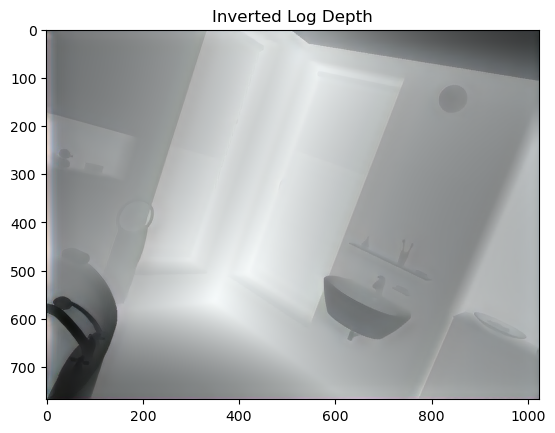

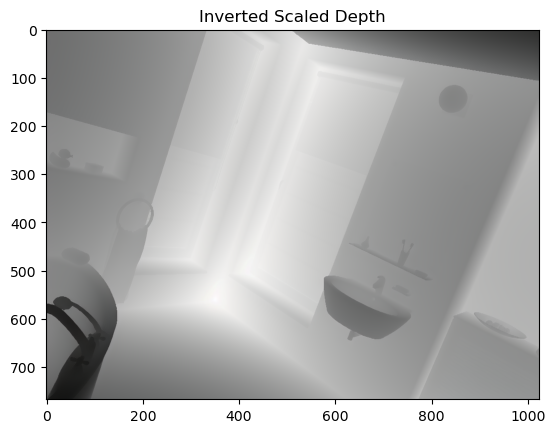

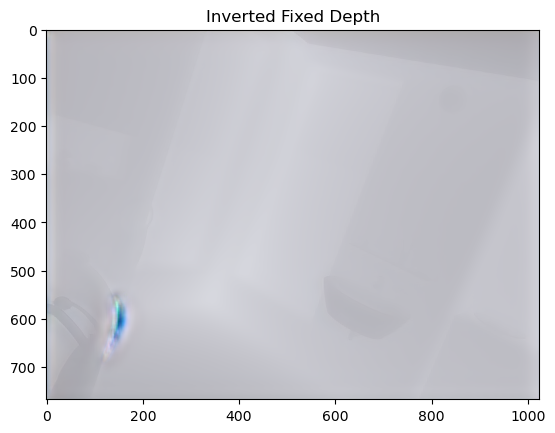

In [10]:
invert_log = 0.10 * torch.exp(log_out[0].detach().cpu().squeeze(0).permute(1, 2, 0) * np.log(80/0.10))

diff_abss_log = (invert_log - rgb_log.detach().cpu().squeeze(0).permute(1, 2, 0)).abs()
print("log_abs",diff_abss_log.min(), diff_abss_log.max(), diff_abss_log.mean(), diff_abss_log.std())

 
invert_scaled = depth.min().cpu() + (depth.max() - depth.min()).cpu() * scaled_out[0].detach().cpu().squeeze(0).permute(1, 2, 0)
diff_abss_scaled = (invert_scaled - rgb_scaled.detach().cpu().squeeze(0).permute(1, 2, 0)).abs()
print("scaled_diff_abs",diff_abss_scaled.min(), diff_abss_scaled.max(), diff_abss_scaled.mean(), diff_abss_scaled.std())



invert_fixed = 0.10 + (80 - 0.10) * fixed_out[0].detach().cpu().squeeze(0).permute(1, 2, 0)
diff_abss_fixed = (invert_fixed - rgb_fixed.detach().cpu().squeeze(0).permute(1, 2, 0)).abs()
print("fixed_abs",diff_abss_fixed.min(), diff_abss_fixed.max(), diff_abss_fixed.mean(), diff_abss_fixed.std())


plt.imshow(normalize(invert_log))
plt.title("Inverted Log Depth")
plt.show()

plt.imshow(normalize(invert_scaled))
plt.title("Inverted Scaled Depth")
plt.show()

plt.imshow(normalize(invert_fixed))
plt.title("Inverted Fixed Depth")
plt.show()